In [1]:
from copy import deepcopy
import os
import random
import sys

In [2]:
from matplotlib import cm
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.mplot3d.axes3d import Axes3D
from torch.utils.data import Dataset, DataLoader, random_split
from torchdata import datapipes as DataPipe
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import scipy.optimize as SciOpt
import toml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo

In [3]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lcm.model.builder import LearnedCostModelBuilder, ClassicModel, FlexibleModel
import endure.lcm.data.generator as Gen
from endure.ltune.data.generator import LTuneGenerator
from endure.lsm.types import Policy, LSMDesign, System
from endure.lsm.cost import EndureCost
import endure.lsm.cost_model as CostFunc

In [4]:
model_path = '/data/models/lcm/qcost-10-06-v2/'
config = Reader.read_config(os.path.join(model_path, 'endure.toml'))
lsm_design = config['lsm']['design']

In [5]:
config['job']['LCMTrain']

{'max_epochs': 40,
 'save_dir': 'models/lcm/qcost-10-06-v2',
 'use_gpu_if_avail': True,
 'loss_fn': 'Huber',
 'optimizer': 'Adam',
 'lr_scheduler': 'CosineAnnealing',
 'no_checkpoint': False,
 'train': {'dir': 'train-data/qcost-t30',
  'format': 'parquet',
  'batch_size': 8192,
  'shuffle': True,
  'num_workers': 12,
  'drop_last': True},
 'test': {'dir': 'test-data/qcost-t30',
  'format': 'parquet',
  'batch_size': 65536,
  'shuffle': False,
  'num_workers': 4,
  'drop_last': True}}

In [6]:
lsm_design

'QLSM'

In [7]:
if lsm_design in ['Level', 'Tier']:
    gen = Gen.ClassicGenerator(config)
elif lsm_design == 'KLSM':
    gen = Gen.KHybridGenerator(config)
elif lsm_design in ['QLSM', 'QLSMIntegerVars']:
    gen = Gen.QCostGenerator(config)
else:
    gen = Gen.ClassicGenerator(config)
cf = EndureCost(config)

# Loss Graph

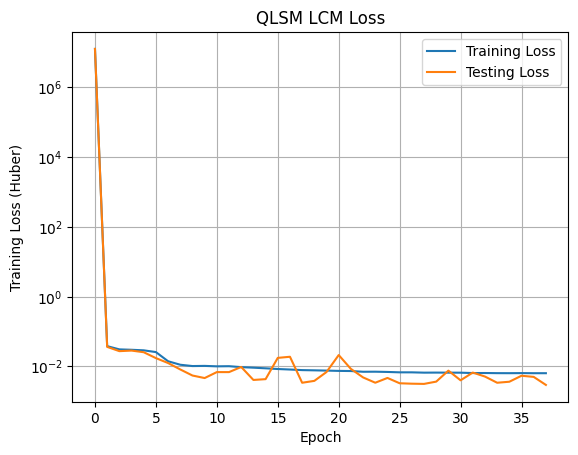

In [8]:
losses = pd.read_csv(os.path.join(model_path, 'losses.csv'))
losses = losses.loc[:100]
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({config["job"]["LCMTrain"]["loss_fn"]})')
ax.set_yscale('log')
ax.grid()
ax.set_title(f'{lsm_design} LCM Loss')
_ = ax.legend()

In [9]:
losses.idxmin()

epoch          0
train_loss    36
test_loss     37
dtype: int64

# Building

## Model

In [10]:
model_name = os.path.join(model_path, 'best.model')
# model_name = os.path.join(model_path, 'checkpoints/epoch_02.checkpoint')
# last_checkpoint = os.listdir(os.path.join(model_path, 'checkpoints'))[-1]
# model_name = os.path.join(model_path, 'checkpoints', last_checkpoint)

builder = LearnedCostModelBuilder(config)
model = builder.build_model()
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
load_status = model.load_state_dict(model_params)
model.eval()
load_status

<All keys matched successfully>

In [11]:
torchinfo.summary(model, (1, 70), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
QModel                                   [1, 4]                    --
├─Sequential: 1-1                        [1, 4]                    --
│    └─Linear: 2-1                       [1, 4]                    124
├─Sequential: 1-2                        [1, 4]                    --
│    └─Linear: 2-2                       [1, 4]                    124
├─Sequential: 1-3                        [1, 4]                    --
│    └─BatchNorm1d: 2-3                  [1, 18]                   36
│    └─Linear: 2-4                       [1, 32]                   608
│    └─Dropout: 2-5                      [1, 32]                   --
│    └─ReLU: 2-6                         [1, 32]                   --
│    └─Linear: 2-7                       [1, 32]                   1,056
│    └─Dropout: 2-8                      [1, 32]                   --
│    └─ReLU: 2-9                         [1, 32]                   --
│    └─Li

# Utils

In [12]:
def to_array(workload: dict):
    return np.array([workload[x] for x in ('z0', 'z1', 'q', 'w')])

In [13]:
def l2_norm(a, b):
    return np.linalg.norm((a, b), 2)

In [14]:
def create_classic_input(design, system):
    categories = config['lsm']['size_ratio']['max'] - config['lsm']['size_ratio']['min'] + 1
    T = design.T - config['lsm']['size_ratio']['min']
    T = np.eye(categories, dtype=np.int32)[T]
    policy = np.eye(2, dtype=np.int32)[design.policy.value]
    feats = np.array([z0, z1, q, w, system.B, system.s, system.E, system.H, system.N, design.h])
    inputs = np.concatenate((feats, policy, T))
    
    return inputs

In [15]:
def create_qlsm_input(design, system):
    categories = config['lsm']['size_ratio']['max'] - config['lsm']['size_ratio']['min'] + 1
    one_hot_matrix = np.eye(categories, dtype=np.int32)
    T = design.T - config['lsm']['size_ratio']['min']
    T = one_hot_matrix[T]
    Q = design.Q - 1
    Q = one_hot_matrix[Q]
    feats = [z0, z1, q, w, system.B, system.s, system.E, system.H, system.N, design.h]
    inputs = np.concatenate((np.array(feats), T, Q))
    
    return inputs

In [16]:
def create_qlsm_int_input(design, system):
    categories = config['lsm']['size_ratio']['max'] - config['lsm']['size_ratio']['min'] + 1
    T = design.T - config['lsm']['size_ratio']['min']
    Q = design.Q - 1
    feats = [z0, z1, q, w, system.B, system.s, system.E, system.H, system.N, design.h]
    inputs = np.concatenate((np.array(feats), np.array([T, Q])))
    
    return inputs

In [17]:
def create_klsm_input(design, system):
    categories = config['lsm']['size_ratio']['max'] - config['lsm']['size_ratio']['min'] + 1
    one_hot_matrix = np.eye(categories, dtype=np.int32)
    T = design.T - config['lsm']['size_ratio']['min']
    T = one_hot_matrix[T]
    capacities = (0 if cap == 0 else cap - 1  for cap in design.K)
    one_hot_cap = (one_hot_matrix[cap] for cap in capacities)
    k = np.array(list(one_hot_cap)).flatten()
    feats = [z0, z1, q, w, system.B, system.s, system.E, system.H, system.N, design.h]
    inputs = np.concatenate((np.array(feats), T, k))
    
    return inputs

In [18]:
def eval_lcm(design, system, z0, z1, q, w):
    if design.policy == Policy.KHybrid:
        inputs = create_klsm_input(design, system)
    elif lsm_design == "QLSMIntegerVars":
        inputs = create_qlsm_int_input(design, system)
    elif design.policy in (Policy.Tiering, Policy.Leveling):
        inputs = create_classic_input(design, system)
    elif design.policy == Policy.QFixed:
        inputs = create_qlsm_input(design, system)
    
    inputs = torch.from_numpy(inputs).to(torch.float).view(1, -1)
    model.eval()
    with torch.no_grad():
        pred = model(inputs)
        pred = pred.sum().item()
    return pred

In [19]:
wl = (z0, z1, q, w) = gen._sample_workload(4)
system = gen._sample_system()
design = gen._sample_design(system)
print(design)
print(system)
cf.calc_cost(design, system, z0, z1, q, w), eval_lcm(design, system, z0, z1, q, w)

LSMDesign(h=0.535, T=19, policy=<Policy.QFixed: 3>, Q=17, Y=1.0, Z=1.0, K=[])
System(E=8192, s=4.834959764755488e-08, B=16.0, N=692799993, H=5.3507246253999705, phi=1.0)


(13.602190442430283, 13.821630477905273)

In [20]:
(cf.Z0(design, system)), (cf.Z1(design, system)), (cf.Q(design, system)), (cf.W(design, system))

(16.34091918776446, 8.737779704936482, 45.04686329004297, 0.3251224914915631)

## Learned-Cost-Model Estimation To Analytical

### Single Variable Estimation

In [21]:
# def generate_single_var_estimation(wl, system=None):
#     if system is None:
#         system = System()
#     (z0, z1, q, w) = wl
#     table = []
#     design = LSMDesign(h=2, T=10, policy=Policy.Tiering)
#     # for val in tqdm(np.arange(2, 50, 1)):
#     #     design.T = val
#     for val in tqdm(np.arange(0, 9, 0.1)):
#         design.h = val
#         cost_lcm = eval_lcm(design, system, z0, z1, q, w)
#         cost_acm = cf.calc_cost(design, system, z0, z1, q, w)
#         row = {
#             "z0": z0,
#             "z1": z1,
#             "q": q,
#             "w": w,
#             "B": system.B,
#             "s": system.s,
#             "E": system.E,
#             "H": system.H,
#             "N": system.N,
#             'h': design.h,
#             "policy": 1 if design.policy == Policy.Leveling else 0,
#             'T': design.T,
#             "cost_lcm": cost_lcm,
#             "cost_acm": cost_acm,
#         }
#         table.append(row)
#     table = pd.DataFrame(table)
    
#     return table

In [22]:
# idx = 4
# df = generate_single_var_estimation(to_array(config['workloads'][idx]))

In [23]:
# df['delta'] = abs(df['cost_acm'] - df['cost_lcm'])
# df['norm_delta'] = df['delta'] / df['cost_acm']
# df.sort_values(by='norm_delta', ascending=False)
# df.describe()

In [24]:
# x = df['h']
# y_learned = df['cost_lcm']
# y_analytical = df['cost_acm']

# fig, ax = plt.subplots()
# ax.plot(x, y_learned, label='Surrogate (Learned) Function')
# ax.plot(x, y_analytical, label='Analytical Function')
# ax.set_xlabel('Size Ratio (T)')
# ax.set_ylabel('Average I/O per Query')
# ax.set_title('Single Variable Estimation')
# ax.legend()
# config['workloads'][idx]

### Random Configuration Estimation

In [25]:
def generate_random_samples(num_samples=100):
    table = []
    list_of_bad_examples = []
    for _ in tqdm(range(num_samples)):
        row = {}
        z0, z1, q, w = gen._sample_workload(4)
        system = gen._sample_system()
        design = gen._sample_design(system)
        cost_lcm = eval_lcm(design, system, z0, z1, q, w)
        cost_acm = cf.calc_cost(design, system, z0, z1, q, w)
        row = {
            "z0": z0,
            "z1": z1,
            "q": q,
            "w": w,
            "B": system.B,
            "s": system.s,
            "E": system.E,
            "H": system.H,
            "N": system.N,
            'h': design.h,
            'T': design.T,
        }
        if design.policy in (Policy.Tiering, Policy.Leveling):
            row["policy"] = design.policy.value
        elif design.policy == Policy.KHybrid:
            for idx, k in enumerate(design.K):
                row[f"K_{idx}"] = k
        elif design.policy == Policy.QFixed:
            row['Q'] = design.Q
        row['cost_lcm'] = cost_lcm
        row['cost_acm'] = cost_acm
        norm_delta = (cost_acm - cost_lcm) / cost_acm
        if norm_delta < -5:
            print(norm_delta, system, design, z0, z1, q, w)
            list_of_bad_examples.append((norm_delta, z0, z1, q, w, design, system))
        table.append(deepcopy(row))
    table = pd.DataFrame(table)
    
    return table, list_of_bad_examples

In [26]:
num_samples = 10000
table = []
bad = []
for _ in tqdm(range(num_samples)):
    row = {}
    z0, z1, q, w = gen._sample_workload(4)
    system = gen._sample_system()
    design = gen._sample_design(system)
    cost_lcm = eval_lcm(design, system, z0, z1, q, w)
    cost_acm = cf.calc_cost(design, system, z0, z1, q, w)
    row = {
        "z0": z0,
        "z1": z1,
        "q": q,
        "w": w,
        "B": system.B,
        "s": system.s,
        "E": system.E,
        "H": system.H,
        "N": system.N,
        'h': design.h,
        'T': design.T,
    }
    if design.policy in (Policy.Tiering, Policy.Leveling):
        row["policy"] = design.policy.value
    elif design.policy == Policy.KHybrid:
        for idx, k in enumerate(design.K):
            row[f"K_{idx}"] = k
    elif design.policy == Policy.QFixed:
        row['Q'] = design.Q
    row['cost_lcm'] = cost_lcm
    row['cost_acm'] = cost_acm
    norm_delta = (cost_acm - cost_lcm) / cost_acm
    if norm_delta < -1:
        print(norm_delta, system, design, z0, z1, q, w)
        bad.append((norm_delta, z0, z1, q, w, design, system))
    table.append(deepcopy(row))
table = pd.DataFrame(table)
df = table
# df, bad = generate_random_samples(num_samples)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [27]:
df['delta'] = (df['cost_acm'] - df['cost_lcm'])
df['norm_delta'] = df['delta'] / df['cost_acm']
df.sort_values(by='norm_delta', ascending=False)

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
3151,0.057,0.040,0.001,0.902,64.0,5.793437e-08,1024,15.268744,804595421,6.758,2,1,0.065646,0.253624,0.187978,0.741169
1926,0.745,0.169,0.003,0.083,4.0,5.877848e-09,8192,16.335021,464586141,7.579,4,1,0.265454,0.638680,0.373225,0.584370
6843,0.193,0.137,0.007,0.663,64.0,8.729913e-08,2048,14.014381,647293649,2.589,20,1,0.246614,0.585157,0.338543,0.578551
4306,0.444,0.306,0.001,0.249,64.0,1.362485e-09,1024,7.677557,938689492,4.127,15,1,0.247258,0.513114,0.265857,0.518124
8254,0.280,0.328,0.004,0.388,64.0,2.770959e-08,1024,5.671859,682688360,2.069,26,1,0.379364,0.737330,0.357966,0.485490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876,0.741,0.080,0.032,0.147,64.0,3.592886e-08,1024,17.603317,847361308,14.629,27,4,0.524806,0.355966,-0.168840,-0.474314
4123,0.800,0.011,0.030,0.159,32.0,7.559329e-08,4096,13.320264,688858865,4.169,29,3,1.030912,0.695717,-0.335194,-0.481797
3927,0.722,0.036,0.091,0.151,32.0,6.509080e-09,2048,18.008238,243298370,10.716,9,1,0.586857,0.389414,-0.197443,-0.507025
7150,0.865,0.048,0.001,0.086,16.0,5.051288e-08,2048,13.272770,395225391,6.608,23,8,0.731731,0.457334,-0.274397,-0.599993


In [28]:
# bad

In [29]:
# cost, z0, z1, q, w, design, system = bad[0]
# z0, z1, q, w, design, system
# cf.calc_cost(design, system, z0, z1, q, w), eval_lcm(design, system, z0, z1, q, w)

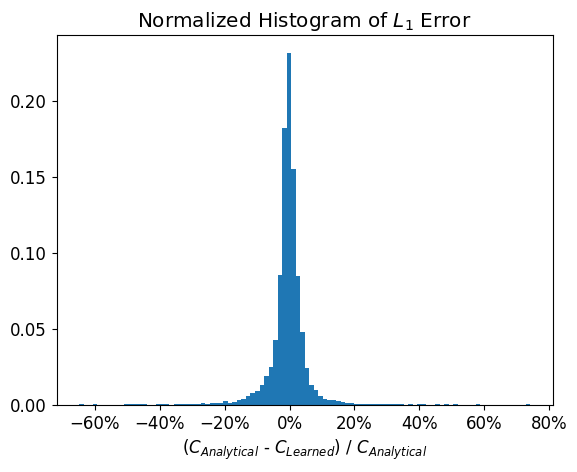

In [30]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
data = df['norm_delta'].values
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data))
ax.set_xlabel('($C_{Analytical}$ - $C_{Learned}$) / $C_{Analytical}$')
ax.set_title('Normalized Histogram of $L_1$ Error')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))

In [44]:
data = df[(df.norm_delta < 0.01) & (df.norm_delta > -0.05)]
data.sort_values(by='norm_delta')

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
6535,0.127,0.133,0.305,0.435,4.0,1.572804e-08,8192,9.246351,974041773,5.287,8,2,5.647394,5.378483,-0.268911,-0.049998
105,0.404,0.485,0.007,0.104,32.0,9.516159e-08,4096,16.027022,864869981,4.357,7,2,0.845455,0.805263,-0.040193,-0.049913
7775,0.325,0.503,0.019,0.153,16.0,1.269905e-08,4096,12.435677,663036957,0.282,25,17,11.627880,11.075746,-0.552134,-0.049851
8790,0.102,0.513,0.067,0.318,64.0,5.996184e-08,1024,8.443982,712767060,0.752,7,2,1.608301,1.531978,-0.076323,-0.049820
4951,0.427,0.525,0.035,0.013,32.0,4.176630e-08,2048,5.731814,482578398,0.795,5,1,1.407176,1.340410,-0.066766,-0.049810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9407,0.086,0.276,0.204,0.434,16.0,2.462826e-08,8192,19.235799,747162466,4.985,23,17,7.990903,8.071207,0.080304,0.009949
5224,0.059,0.560,0.230,0.151,16.0,2.159256e-08,4096,19.046642,989912824,8.879,8,7,5.558497,5.614443,0.055946,0.009965
416,0.224,0.296,0.184,0.296,32.0,9.764419e-08,4096,9.716045,440222002,5.099,25,18,8.166287,8.248554,0.082267,0.009973
1549,0.534,0.144,0.320,0.002,128.0,7.004341e-08,1024,10.881592,252787685,4.385,13,10,7.407289,7.482056,0.074767,0.009993


In [32]:
cutoff = 1
df[(df['norm_delta'] > cutoff) | (df['norm_delta'] < -cutoff)]

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta


In [33]:
def plot_workload_trend(df, trend='stune_T'):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

    ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
    ax.set_ylabel('Range-Reads (q)', labelpad=10)
    ax.set_zlabel('Writes (w)', labelpad=10)

    sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df[trend], cmap='viridis')
    cbar = plt.colorbar(sc)
    cbar.set_label(trend)
    
    return fig, ax, sc, cbar

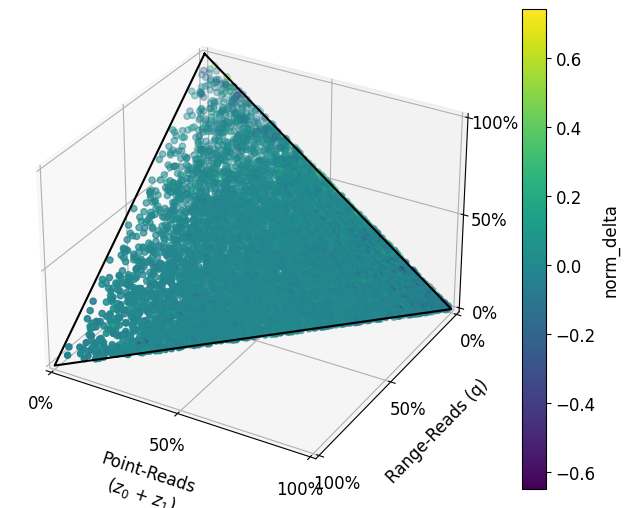

In [34]:
fig, ax, sc, cbar = plot_workload_trend(df, 'norm_delta')

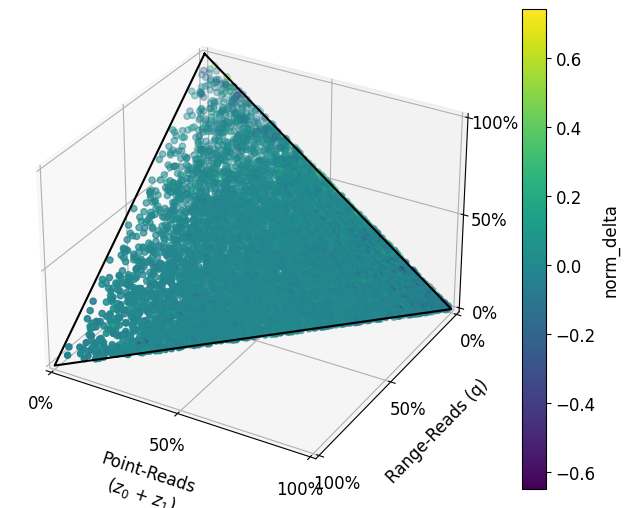

In [35]:
fig, ax, sc, cbar = plot_workload_trend(df[(df.norm_delta < 1) & (df.norm_delta > -1)], 'norm_delta')

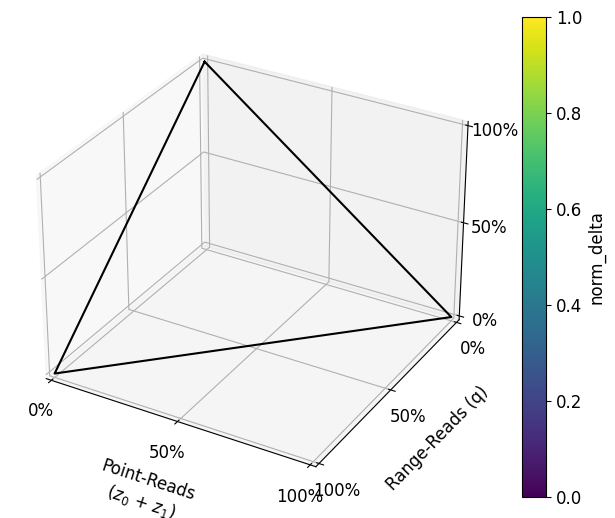

In [36]:
fig, ax, sc, cbar = plot_workload_trend(df[(df.norm_delta > 1) | (df.norm_delta < -1)], 'norm_delta')

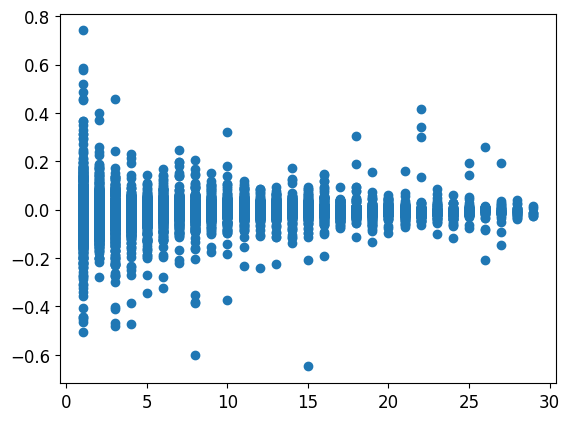

In [37]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
ax.scatter(df['Q'], df.norm_delta)
None

In [38]:
df.s

0       3.816385e-08
1       1.192206e-08
2       3.995805e-08
3       4.198991e-08
4       2.662297e-08
            ...     
9995    3.341727e-08
9996    1.751923e-08
9997    8.522126e-08
9998    6.755470e-08
9999    2.916831e-08
Name: s, Length: 10000, dtype: float64

In [39]:
config['lsm']

{'design': 'QLSM',
 'max_levels': 20,
 'size_ratio': {'max': 31, 'min': 2},
 'bits_per_elem': {'max': 9.9, 'min': 0},
 'system': {'B': 4,
  'phi': 1,
  's': 2e-07,
  'E': 8192,
  'H': 10,
  'M': -1,
  'N': 1000000000}}

In [40]:
table = []
z0, z1, q, w = gen._sample_workload(4)
system = gen._sample_system()
design = gen._sample_design(system)
design.policy = Policy.Leveling

for size_ratio in range(config['lsm']['size_ratio']['min'], config['lsm']['size_ratio']['max']):
    for bpe in np.arange(config['lsm']['bits_per_elem']['min'], system.H, 0.1):
        design.T = size_ratio
        design.h = bpe
        cost_lcm = eval_lcm(design, system, z0, z1, q, w)
        cost_acm = cf.calc_cost(design, system, z0, z1, q, w)
        row = {
            "z0": z0,
            "z1": z1,
            "q": q,
            "w": w,
            "B": system.B,
            "s": system.s,
            "E": system.E,
            "H": system.H,
            "N": system.N,
            'h': design.h,
            'T': design.T,
        }
        row["policy"] = design.policy.value
        row["cost_lcm"] = cost_lcm
        row["cost_acm"] = cost_acm
        table.append(row)
table = pd.DataFrame(table)

RuntimeError: unflatten: Provided sizes [-1, 30] don't multiply up to the size of dim 1 (32) in the input tensor

In [ ]:
from mpl_toolkits.mplot3d import proj3d

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": "3d"})
Y = range(config['lsm']['size_ratio']['min'], config['lsm']['size_ratio']['max'])
X = np.arange(config['lsm']['bits_per_elem']['min'], system.H, 0.1)
X, Y = np.meshgrid(X, Y)
lcmZ = table.cost_lcm.values.reshape(X.shape)
acmZ = table.cost_acm.values.reshape(X.shape)

surfa = ax.plot_surface(Y, X, acmZ, color='tab:gray',# cmap=cm.Greys,
                       linewidth=0, antialiased=True,
                       alpha=0.5, label='Analytical')
surfa._facecolors2d = surfa._facecolor3d
surfa._edgecolors2d = surfa._edgecolor3d
surfb = ax.plot_surface(Y, X, lcmZ, color='tab:blue',# cmap=cm.Greens,
                       linewidth=0.1, antialiased=True,
                       alpha=0.5, label='Learned')
surfb._facecolors2d = surfb._facecolor3d
surfb._edgecolors2d = surfb._edgecolor3d

f = lambda x,y,z: proj3d.proj_transform(x,y,z, ax.get_proj())[:2]
ax.legend(['Analytical', 'Learned'], bbox_to_anchor=f(30, 6, 6), bbox_transform=ax.transData)
ax.set_xlabel('Size Ratio')
ax.set_ylabel('Filter Bits/Key')
ax.set_zlabel('I/O per Query')
ax.set_box_aspect(aspect=None, zoom=0.9)

### 